# 4.3 - Train a model for each dataset category, comparing it to random data

In [1]:
import os
import sys
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
import block_sampler
import batch_encoder
from dataset import Dataset
from report import Reporter2
from trainer import Trainer, TrainResults
from batch_encoder import Dataset, one_hot
from block_sampler import count_sectors, BlockSamplerByFile, RandomSampler
from batch_encoder import xs_encoder_8bits_11, BatchEncoder, xs_encoder_one_hot
from filter_random import gen_rndchk_models, evaluate_rnd_model, filter_dataset

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.3-randomness'
os.makedirs(result_dir, exist_ok=True)

In [3]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()
rawtset, rawvset = rawset.rnd_split_fraction_by_category(0.5)

In [4]:
def CM(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(classes, (32,), strides=1)(last)
    last = MaxPooling1D(pool_size=481, strides=1)(last)
    last = Flatten()(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [5]:
class CatSampler:
    def __init__(self, model, blksampler, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = np.argmax(predict, axis=-1)
            blks = [x for x,y in zip(blks, predict) if y == self.cat]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.blksampler.dataset.categories[self.cat])


In [6]:
class ThrSampler:
    def __init__(self, model, blksampler, threshold, cat):
        self.model = model
        self.blksampler = blksampler
        self.dataset = blksampler.dataset
        self.threshold = threshold
        self.cat = cat

    def __iter__(self):
        fails=0
        tbenc = iter(BatchEncoder(self.blksampler, 100,
                                  xs_encoder='one_hot'))
        while True:
            blks = next(tbenc)[0]
            predict = self.model.predict(blks)
            predict = predict[:,0]-predict[:,1]
            blks = [x for x,y in zip(blks, predict) if y > self.threshold]
            if len(blks) == 0:
                fails += 1
                if fails > 1000:
                    raise Exception("all blocks seems to be the wrong kind")
                continue
            fails=0
            for blk in blks:
                yield block_sampler.BlockInstance(np.argmax(blk, axis=-1), self.cat)


In [7]:
steps_per_epoch=28
patience=10

In [8]:
import models
from block_sampler import BlockSamplerByCategory
from batch_encoder import BatchEncoder
from collections import namedtuple
import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

TrainResults = namedtuple(
    'TrainResults', ['model', 'history', 'metrics', 'elapsed'])

class RandomTrainer:
    def __init__(self,
                 model,
                 xs_encoder='one_hot',
                 validation_steps=steps_per_epoch,
                 steps_per_epoch=steps_per_epoch,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=patience):
        self.model = model
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience

    def train(self, tset, vset, previous_model=None, previous_model2=None):
        tsampler = BlockSamplerByFile(tset)
        if previous_model:
            tsampler = CatSampler(previous_model, tsampler, 0)
        if previous_model2:
            tsampler = CatSampler(previous_model2, tsampler, 0)
        trsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
        tbenc = BatchEncoder(trsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        vsampler = BlockSamplerByFile(vset)
        if previous_model:
            vsampler = CatSampler(previous_model, vsampler, 0)
        if previous_model2:
            vsampler = CatSampler(previous_model2, vsampler, 0)
        vrsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
        vbenc = BatchEncoder(vrsampler, self.batch_size,
                             xs_encoder=self.xs_encoder)

        return self._train(tbenc,vbenc)

    def _train(self, tbenc, vbenc):
        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            # TensorBoard(
            #     log_dir=os.path.join(log_dir, model.name),
            #     # update_freq=3100,
            # ),
#             LambdaCallback(on_epoch_end = lambda epoch, logs: print(logs['val_categorical_accuracy'])),
        ],
            use_multiprocessing=False,
            workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [9]:
def rndgen(block_instance=False):
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        if block_instance:
            yield (rdata, np.array([0,1]*100).reshape(100,2))
        else:
            yield rdata

# Train pass1 models

In [10]:
r = Reporter2(result_dir + "/pass1.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    model = CM(2, 256)
    print(cat)
    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=28,
        validation_steps=28,
        patience=10,
    ).train(tset, vset)
    val_acc = result.history.history['val_categorical_accuracy'][-1]
    
    vsampler = BlockSamplerByFile(vset)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass1.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
rtf
val_acc = 0.99785715 struct_acc= 0.996 rnd_acc= 1.0
xls
val_acc = 0.9882143 struct_acc= 0.978 rnd_acc= 1.0
ps
val_acc = 0.9632143 struct_acc= 0.924 rnd_acc= 1.0
pdf
val_acc = 0.7292857 struct_acc= 0.461 rnd_acc= 0.996
doc
val_acc = 0.9235714 struct_acc= 0.84 rnd_acc= 1.0
dwf
val_acc = 0.5921429 struct_acc= 0.355 rnd_acc= 0.857
dbase3
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
log
val_acc = 1.0 struct_acc= 1.0 rnd_acc= 1.0
xml
val_acc = 0.99892855 struct_acc= 0.998 rnd_acc= 1.0
java
val_acc = 0.9992857 struct_acc= 1.0 rnd_acc= 1.0
png
val_acc = 0.6160714 struct_acc= 0.273 rnd_acc= 0.976
pptx
val_acc = 0.7192857 struct_acc= 0.586 rnd_acc= 0.89
jpg
val_acc = 0.9142857 struct_acc= 0.887 rnd_acc= 0.957
wp
val_acc = 0.99392855 struct_acc= 0.992 rnd_acc= 1.0
kmz
val_acc = 0.7246429 struct_acc= 0.455 rnd_acc= 0.998
sql
val_acc = 0.99964285 struct_acc= 0.999 rnd_acc= 1.0
gz


# Load data

In [13]:
data = pd.read_csv(result_dir + '/pass1.tsv', sep='\t')
data = data.sort_values('val_acc')
data

,category,val_acc,struct_acc,rnd_acc,Time,Epochs
5,dwf,0.592143,0.355,0.857,12m04s,15
16,gz,0.610000,0.320,0.872,17m23s,21
10,png,0.616071,0.273,0.976,15m34s,19
20,swf,0.699286,0.405,0.976,26m12s,32
11,pptx,0.719286,0.586,0.890,20m24s,23
26,gif,0.719643,0.425,0.991,37m27s,47
14,kmz,0.724643,0.455,0.998,15m07s,19
3,pdf,0.729286,0.461,0.996,30m37s,37
18,ppt,0.730714,0.472,0.997,40m21s,49
27,pps,0.742500,0.546,0.985,31m23s,40


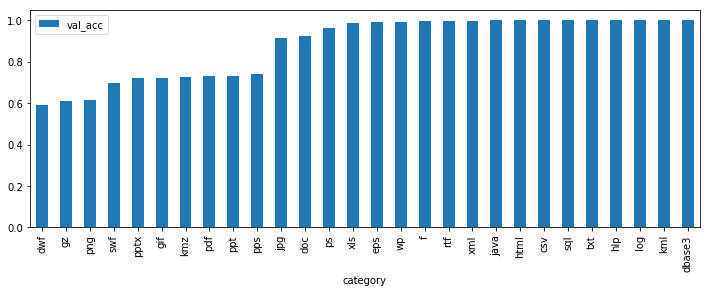

In [14]:
data.plot.bar('category', ['val_acc'], figsize=(12,4))
plt.show()

# Train pass2 models

In [15]:
if os.path.exists(result_dir + "/pass2.tsv"):
    os.remove(result_dir + "/pass2.tsv")
r = Reporter2(result_dir + "/pass2.tsv")
by_categoryT = rawtset.by_category()
by_categoryV = rawvset.by_category()
threshold=0.5
for cat in by_categoryT.keys():
    tset = by_categoryT[cat]
    vset = by_categoryV[cat]
    tset.rebuild_categories(categories=[cat, 'zzz'])
    vset.rebuild_categories(categories=[cat, 'zzz'])
    if data.set_index('category').loc[cat].val_acc > 0.98:
        continue
    previous_model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    model = CM(2, 256)
    print(cat)
    batch_size = 100
    tsampler = BlockSamplerByFile(tset)
    tsampler = ThrSampler(previous_model, tsampler, threshold, cat)
    tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat=tset.categories[0])
    tbenc = BatchEncoder(tsampler, batch_size,
                         xs_encoder='one_hot')

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vsampler = RandomSampler(vsampler, rnd_cat='zzz', not_rnd_cat=vset.categories[0])
    vbenc = BatchEncoder(vsampler, batch_size,
                         xs_encoder='one_hot')

    result = RandomTrainer(
        model,
        batch_size=100,
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch,
        patience=patience,
    )._train(tbenc,vbenc)
    val_acc = result.history.history['val_categorical_accuracy'][-1]

    vsampler = BlockSamplerByFile(vset)
    vsampler = ThrSampler(previous_model, vsampler, threshold, cat)
    vbenc = BatchEncoder(vsampler, 100,xs_encoder='one_hot')
    struct_acc = model.evaluate_generator(iter(vbenc), steps=10)[-1]
    
    rnd_acc = model.evaluate_generator(rndgen(True), steps=10)[-1]
    
    print('val_acc =', val_acc, 'struct_acc=', struct_acc, 'rnd_acc=', rnd_acc)
    r.line(category=cat,
           val_acc=val_acc,
           struct_acc=struct_acc,
           rnd_acc=rnd_acc,
           **report.report_elapsed(**result._asdict()),
           **report.report_epochs(**result._asdict()),
          )
    h5_path = os.path.join(result_dir, '%s_pass2.h5' % cat)
    tf.keras.Model.save(model, h5_path)
r.close()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
ps


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

# Load pass2 data

In [ ]:
data2 = pd.read_csv(result_dir + "/pass2.tsv", sep='\t')
data2 = data2.sort_values('val_acc')
data2

In [ ]:
data2.plot.bar('category', ['val_acc'], figsize=(12,4))
plt.show()

data3 = pd.read_csv(result_dir + "/pass3.tsv", sep='\t')
data3 = data3.sort_values('val_acc')
data3

# Use models to evaluate dataset

In [ ]:
r = Reporter2(result_dir + "/evaluate.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)   
    not_random = len(predict[predict==0])/datalen
    
    predict = model.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/datalen
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

# Load evaluation data

In [ ]:
data3 = pd.read_csv(result_dir + "/evaluate.tsv", sep='\t')
data3 = data3.sort_values('true_not_random')
data3

In [ ]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data3['cat'], data3['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data3.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [ ]:
data3.mean()

In [ ]:
1-np.sum(data3['true_not_random'])/28

In [ ]:
1-(np.sum(data3['true_not_random'])+(1-0.62))/28

# Roc pass1

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
by_category = rawset.by_category()
cat = 'jpg'
dataset = by_category[cat]
dataset.rebuild_categories(categories=['jpg', 'zzz'])

model = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)

In [ ]:
tsampler = BlockSamplerByFile(dataset)
tsampler = RandomSampler(tsampler, rnd_cat='zzz', not_rnd_cat='jpg')

tbenc = BatchEncoder(tsampler,
                     batch_size=1000,
                     xs_encoder='one_hot')
xs, ys = next(iter(tbenc))

In [ ]:
datalen = len(xs)
predict = model.predict(xs, batch_size=100)
# predict = np.argmax(predict, axis=-1)

In [ ]:
score = predict[:,0]-predict[:,1]
mask = score > 0.9
print(len(score[mask]), len(score))
fpr, tpr, thresholds = roc_curve(ys[:,0][mask], score[mask])
mask = thresholds > 0
fpr[mask], tpr[mask], thresholds[mask]

In [ ]:
plt.plot(fpr, tpr)

In [ ]:
plt.hist(predict[:,0]-predict[:,1])

# Use models to evaluate dataset - using pass2

In [ ]:
def rndgen():
    while True:
        rdata = np.random.randint(0, 256, (100,512), dtype='int')
        rdata = one_hot(rdata, 256)
        yield rdata

In [ ]:
if os.path.exists(result_dir + "/evaluate2.tsv"):
    os.remove(result_dir + "/evaluate2.tsv")
r = Reporter2(result_dir + "/evaluate2.tsv")
by_category = rawset.by_category()
for cat, dataset in by_category.items():
    model1 = tf.keras.models.load_model(result_dir + '/%s_pass1.h5' % cat)
    tsampler = BlockSamplerByFile(dataset)
    tbenc = BatchEncoder(tsampler,
                         batch_size=1000,
                         xs_encoder='one_hot')
    xs, _ = next(iter(tbenc))
    datalen = len(xs)
    predict = model1.predict(xs, batch_size=100)
    predict = np.argmax(predict, axis=-1)

    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        model2 = tf.keras.models.load_model(result_dir + '/%s_pass2.h5' % cat)
        xs = xs[predict==0]
        datalen = len(xs)
        predict = model2.predict(xs, batch_size=100)
        predict = np.argmax(predict, axis=-1)

    not_random = len(predict[predict==0])/datalen
    
    if os.path.exists(result_dir + '/%s_pass2.h5' % cat):
        predict = model2.predict_generator(rndgen(), steps=10)
    else:
        predict = model1.predict_generator(rndgen(), steps=10)
    predict = np.argmax(predict, axis=-1)   
    random = len(predict[predict==1])/(10*100)
    
    true_not_random = not_random - (1-not_random)*(1-random)/random
    
    print(cat, not_random, random, true_not_random )
    r.line(cat=cat, not_random=not_random, random=random, true_not_random=true_not_random)
r.close()

# Load evaluation data 2

In [ ]:
data4 = pd.read_csv(result_dir + "/evaluate2.tsv", sep='\t')
data4 = data4.sort_values('true_not_random')
data4

In [ ]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12,4))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid(linestyle='--', which='minor')
ax.bar(data4['cat'], data4['true_not_random'], fill=False)
plt.xticks(rotation='vertical')
ax.tick_params(labelsize=14)
for i in range(28):
    cat = rawset.ix_to_cat[i]
    v = data4.iloc[i,3]
    t = ax.annotate('%0.2f'%v, (i-0.3, v-0.06),fontsize=14)
    t.set_rotation(90)
# data3.plot.bar('cat', ['not_random'], figsize=(12,4))
# plt.show()

In [ ]:
data4.mean()

In [ ]:
1-np.sum(data4['true_not_random'])/28

In [ ]:
1-(np.sum(data4['true_not_random'])+(1-0.62))/28